In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,  LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers

In [61]:
df = pd.read_csv("C:\\Users\\sumit\\Desktop\\LLM\\Deep Learning\\Lending Club Loan Data Analysis\\loan_data.csv")
df.head(10)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,0,0
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,0,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,0,0,1
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0,0


In [62]:
# ------------------------
# 2. FEATURE TRANSFORMATION
# ------------------------
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [63]:
# ------------------------
# 3. EXPLORATORY DATA ANALYSIS
# ------------------------

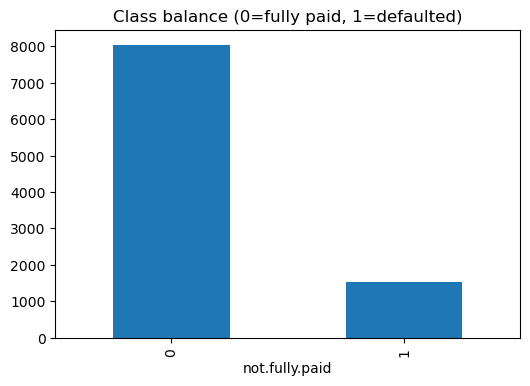

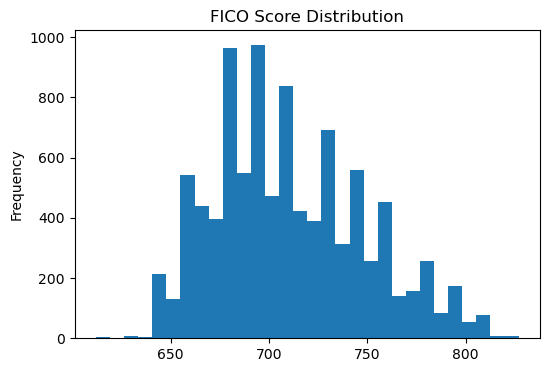

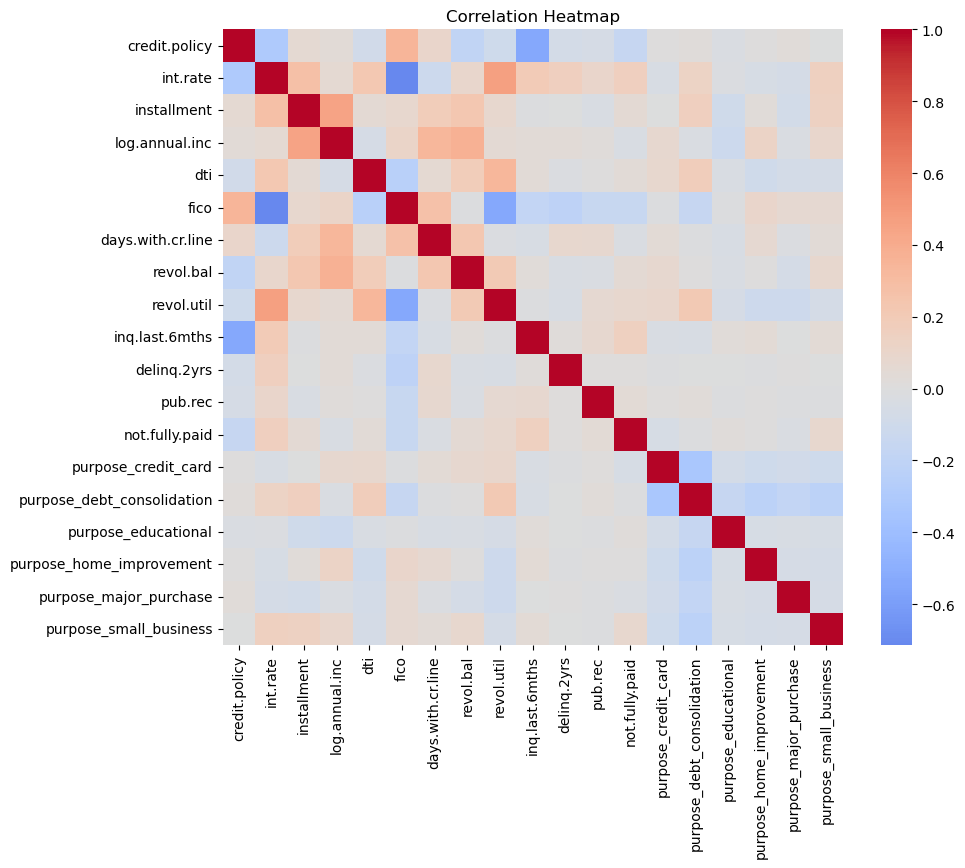

In [64]:
plt.figure(figsize=(6,4))
df['not.fully.paid'].value_counts().plot(kind='bar')
plt.title("Class balance (0=fully paid, 1=defaulted)")
plt.show()

if 'fico' in df.columns:
    plt.figure(figsize=(6,4))
    df['fico'].plot(kind='hist', bins=30)
    plt.title("FICO Score Distribution")
    plt.show()

# correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

In [65]:
# ------------------------
# 4. ADDITIONAL FEATURE ENGINEERING
# Drop highly correlated features
# ------------------------

In [66]:
def drop_highly_correlated_features(dataframe, threshold=0.9, target=None):
    corr_matrix = dataframe.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    if target in to_drop:
        to_drop.remove(target)
    return dataframe.drop(columns=to_drop, errors="ignore"), to_drop

df_reduced, dropped_features = drop_highly_correlated_features(df, threshold=0.9, target='not.fully.paid')
print("Dropped features:", dropped_features)

Dropped features: []


In [67]:
# ------------------------
# 5. MODELING (Deep Learning)
# ------------------------

In [68]:
X = df_reduced.drop(columns=['not.fully.paid'])
y = df_reduced['not.fully.paid']

In [69]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [71]:
# scale features
scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [72]:
input_dim = X_train.shape[1]

In [73]:
# compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(cls): w for cls, w in zip(classes, class_weights)}

In [74]:
# build Keras model
def build_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1])

In [75]:
# train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2627 - loss: 0.7598 - val_accuracy: 0.6566 - val_loss: 0.6656
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5656 - loss: 0.6967 - val_accuracy: 0.6631 - val_loss: 0.6527
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6097 - loss: 0.6714 - val_accuracy: 0.6949 - val_loss: 0.6354
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6338 - loss: 0.6636 - val_accuracy: 0.6892 - val_loss: 0.6319
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6389 - loss: 0.6545 - val_accuracy: 0.6852 - val_loss: 0.6265
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6383 - loss: 0.6517 - val_accuracy: 0.7015 - val_loss: 0.6128
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6236 - loss: 0.6881 - val_accuracy: 0.6860 - val_loss: 0.6168
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6434 - loss: 0.6517 - val_accuracy: 0.7007 - val_loss

In [76]:
# evaluate
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Accuracy: 0.6779749478079332
ROC-AUC: 0.6777147276212996
Confusion Matrix:
 [[1138  471]
 [ 146  161]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.71      0.79      1609
           1       0.25      0.52      0.34       307

    accuracy                           0.68      1916
   macro avg       0.57      0.62      0.56      1916
weighted avg       0.79      0.68      0.72      1916



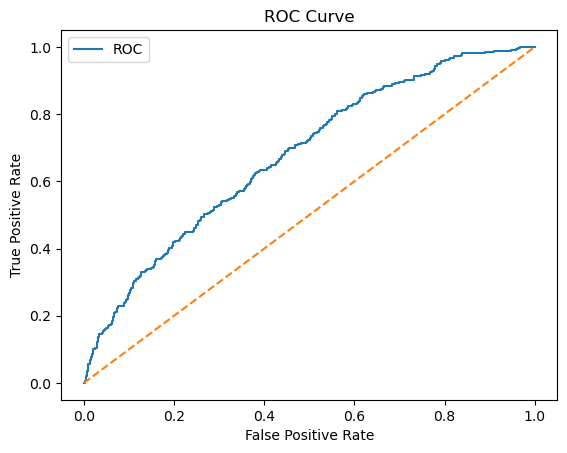

In [77]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [78]:
model.save("loan_default_keras_model.keras") 

## Method 1 – Simple ANN

In [79]:
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
model1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7667 - loss: 0.5317 - val_accuracy: 0.8402 - val_loss: 0.4211
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8439 - loss: 0.4063 - val_accuracy: 0.8376 - val_loss: 0.4178
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8457 - loss: 0.4061 - val_accuracy: 0.8369 - val_loss: 0.4186
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8396 - loss: 0.4091 - val_accuracy: 0.8389 - val_loss: 0.4156
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8452 - loss: 0.3983 - val_accuracy: 0.8369 - val_loss: 0.4153
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8437 - loss: 0.3993 - val_accuracy: 0.8356 - val_loss: 0.4144
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.3999 - val_accuracy: 0.8369 - val_loss: 0.4144
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.3972 - val_accuracy: 0.8343 - val_loss:

In [83]:
# Evaluate
loss1, acc1 = model1.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (Method 1): {acc1:.4f}")

Test Accuracy (Method 1): 0.8288


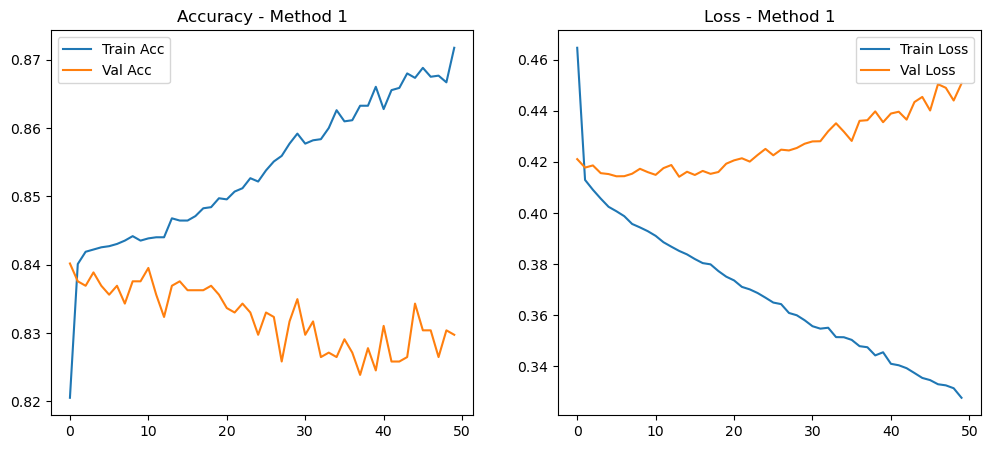

In [84]:
# Plot History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy - Method 1")

plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss - Method 1")
plt.show()

## Method 2 – ANN with Dropout, BatchNorm, EarlyStopping

In [85]:
model2 = Sequential()
model2.add(Dense(128, activation='relu', input_shape=(input_dim,)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(32, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

model2.add(Dense(1, activation='sigmoid'))

In [86]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [87]:
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,249 (51.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [88]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [89]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [90]:
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5542 - loss: 0.7743 - val_accuracy: 0.8337 - val_loss: 0.5566 - learning_rate: 0.0010
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7308 - loss: 0.5680 - val_accuracy: 0.8402 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.4930 - val_accuracy: 0.8369 - val_loss: 0.4317 - learning_rate: 0.0010
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8220 - loss: 0.4536 - val_accuracy: 0.8395 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8328 - loss: 0.4392 - val_accuracy: 0.8363 - val_loss: 0.4216 - learning_rate: 0.0010
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8279 - loss: 0.4405 - val_accuracy: 0.8395 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8284 - loss: 0.4355 - val_acc

In [91]:
loss2, acc2 = model2.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (Method 2): {acc2:.4f}")

Test Accuracy (Method 2): 0.8403


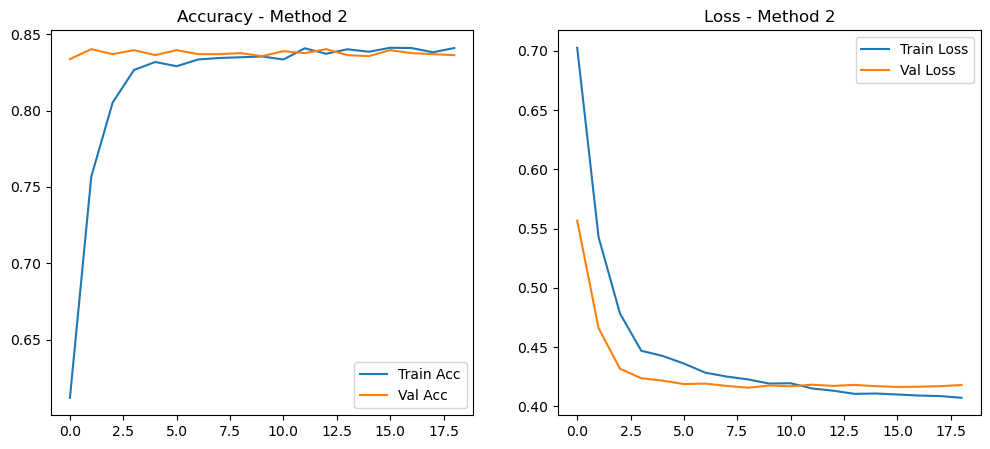

In [92]:
# Plot History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy - Method 2")

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss - Method 2")
plt.show()

## End